In [1]:
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import pandas as pd
import plotly.graph_objects as go
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1)
tf.random.set_seed(1)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

print('Tensorflow version: ', tf.__version__)

Tensorflow version:  2.4.3


In [2]:
# Read the datasets
import glob
path = r'.\dataset\ensdata_ad' # use your path
all_files = glob.glob(path + "/*.csv")
li = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

df_energy = pd.concat(li, axis=0, ignore_index=True)
df_energy = df_energy[pd.to_numeric(df_energy['Hour'], errors='coerce').notnull()]
#df_energy = df_energy.drop_duplicates(keep=False)
df_energy['datetime'] = pd.to_datetime(df_energy['Date'] + ' ' + df_energy['Hour'] + ':00:00')
df_energy = df_energy.drop(['Date','Hour'],axis=1).set_index('datetime')
df_energy.head()

,P(kWh),h_max
datetime,,
2021-01-01 00:00:00,0,33391
2021-01-01 01:00:00,0,33391
2021-01-01 02:00:00,0,33391
2021-01-01 03:00:00,0,33391
2021-01-01 04:00:00,0,33391


In [3]:
df = df_energy.drop(['h_max'],axis =1).reset_index()

In [4]:
df.head()

,datetime,P(kWh)
0,2021-01-01 00:00:00,0
1,2021-01-01 01:00:00,0
2,2021-01-01 02:00:00,0
3,2021-01-01 03:00:00,0
4,2021-01-01 04:00:00,0


In [5]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['datetime'], y=df['P(kWh)'], name='power generation'))
fig.update_layout(showlegend=True, title='Power Generation in Gyeongju from 01-2021 to 06-2022')
fig.show()

In [6]:
train, test = df.loc[df['datetime'] <= '2021-12-31'], df.loc[df['datetime'] > '2022-01-01']

In [7]:
train.tail()

,datetime,P(kWh)
8593,2021-12-30 20:00:00,0
8594,2021-12-30 21:00:00,0
8595,2021-12-30 22:00:00,0
8596,2021-12-30 23:00:00,0
8597,2021-12-31 00:00:00,0


In [8]:
test.head()

,datetime,P(kWh)
8622,2022-01-01 01:00:00,0
8623,2022-01-01 02:00:00,0
8624,2022-01-01 03:00:00,0
8625,2022-01-01 04:00:00,0
8626,2022-01-01 05:00:00,0


In [9]:
train.shape,test.shape

((8598, 2), (4208, 2))

In [10]:
scaler = StandardScaler()
scaler = scaler.fit(train[['P(kWh)']])

train['P(kWh)'] = scaler.transform(train[['P(kWh)']])
test['P(kWh)'] = scaler.transform(test[['P(kWh)']])

<ipython-input-10-46a6ceed6747>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-10-46a6ceed6747>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [11]:
TIME_STEPS=24

def create_sequences(X, y, time_steps=TIME_STEPS):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        Xs.append(X.iloc[i:(i+time_steps)].values)
        ys.append(y.iloc[i+time_steps])
    
    return np.array(Xs), np.array(ys)

X_train, y_train = create_sequences(train[['P(kWh)']], train['P(kWh)'])
X_test, y_test = create_sequences(test[['P(kWh)']], test['P(kWh)'])

In [12]:
print(f'Training shape: {X_train.shape}')

print(f'Testing shape: {X_test.shape}')

Training shape: (8574, 24, 1)
Testing shape: (4184, 24, 1)


In [13]:
model = Sequential()
model.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(rate=0.2))
model.add(RepeatVector(X_train.shape[1]))
model.add(LSTM(32, return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(X_train.shape[2])))
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                4352      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 24, 32)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 24, 32)            8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 32)            0         
_________________________________________________________________
time_distributed (TimeDistri (None, 24, 1)             33        
Total params: 12,705
Trainable params: 12,705
Non-trainable params: 0
____________________________________________________

In [14]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')], shuffle=False)

Epoch 1/100
215/215 [==============================] - 14s 23ms/step - loss: 0.4746 - val_loss: 0.2009
Epoch 2/100
215/215 [==============================] - 3s 15ms/step - loss: 0.2308 - val_loss: 0.1707
Epoch 3/100
215/215 [==============================] - 3s 15ms/step - loss: 0.2033 - val_loss: 0.1581
Epoch 4/100
215/215 [==============================] - 3s 15ms/step - loss: 0.1911 - val_loss: 0.1478
Epoch 5/100
215/215 [==============================] - 3s 14ms/step - loss: 0.1802 - val_loss: 0.1408
Epoch 6/100
215/215 [==============================] - 3s 14ms/step - loss: 0.1740 - val_loss: 0.1285
Epoch 7/100
215/215 [==============================] - 4s 17ms/step - loss: 0.1647 - val_loss: 0.1349
Epoch 8/100
215/215 [==============================] - 3s 16ms/step - loss: 0.1640 - val_loss: 0.1316
Epoch 9/100
215/215 [==============================] - 3s 15ms/step - loss: 0.1598 - val_loss: 0.1241
Epoch 10/100
215/215 [==============================] - 3s 15ms/step - loss: 0.15

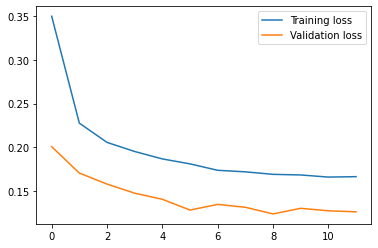

In [15]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend();

In [16]:
model.evaluate(X_test, y_test)

131/131 [==============================] - 1s 6ms/step - loss: 0.2328


0.2328021079301834

Reconstruction error threshold: 2.84435724819871


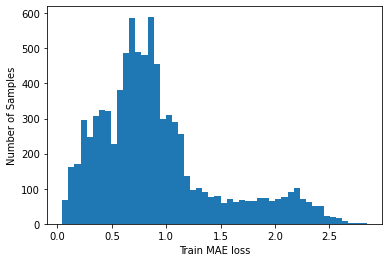

In [17]:
X_train_pred = model.predict(X_train, verbose=0)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples');

threshold = np.max(train_mae_loss)
print(f'Reconstruction error threshold: {threshold}')

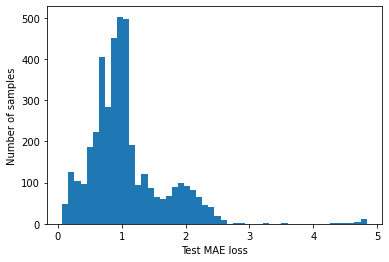

In [18]:
X_test_pred = model.predict(X_test, verbose=0)
test_mae_loss = np.mean(np.abs(X_test_pred-X_test), axis=1)

plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples');

In [19]:
test_score_df = pd.DataFrame(test[TIME_STEPS-1:-1])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = threshold
test_score_df['anomaly'] = test_score_df['loss'] > test_score_df['threshold']
test_score_df['P(kWh)'] = test[TIME_STEPS-1:-1]['P(kWh)']

In [20]:
test_score_df.tail()

,datetime,P(kWh),loss,threshold,anomaly
12824,2022-06-30 18:00:00,-0.528486,0.781367,2.844357,False
12825,2022-06-30 19:00:00,-0.648880,0.781592,2.844357,False
12826,2022-06-30 20:00:00,-0.648880,0.778348,2.844357,False
12827,2022-06-30 21:00:00,-0.648880,0.776705,2.844357,False
12828,2022-06-30 22:00:00,-0.648880,0.775469,2.844357,False


In [21]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test_score_df['datetime'], y=test_score_df['loss'], name='Test loss'))
fig.add_trace(go.Scatter(x=test_score_df['datetime'], y=test_score_df['threshold'], name='Threshold'))
fig.update_layout(showlegend=True, title='Test loss vs. Threshold')
fig.show()

In [22]:
anomalies = test_score_df.loc[test_score_df['anomaly'] == True]
anomalies.head()

,datetime,P(kWh),loss,threshold,anomaly
8727,2022-01-05 15:00:00,5.972809,3.282975,2.844357,True
8746,2022-01-06 15:00:00,14.480676,4.421892,2.844357,True
8765,2022-01-07 15:00:00,14.360281,4.739841,2.844357,True
8784,2022-01-08 15:00:00,14.320150,4.729809,2.844357,True
8803,2022-01-09 15:00:00,10.266874,4.482269,2.844357,True


In [23]:
anomalies.shape

(27, 5)

In [24]:
z = (test_score_df['P(kWh)']).values

zz = scaler.inverse_transform(z.reshape(-1,1))
print(zz.shape)

(4184, 1)


In [25]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test_score_df['datetime'], y=scaler.inverse_transform((test_score_df['P(kWh)'].values).reshape(-1,1)).reshape(-1,), name='power generation'))
fig.add_trace(go.Scatter(x=anomalies['datetime'], y=scaler.inverse_transform((anomalies['P(kWh)'].values).reshape(-1,1)).reshape(-1,), mode='markers', name='Anomaly'))
fig.update_layout(showlegend=True, title='Detected anomalies')
fig.show()

In [26]:
print('finish')

finish
